In [1]:
!pip install pandapower 
!pip install dgl-cu101

     |████████████████████████████████| 5.7MB 12.7MB/s 
     |████████████████████████████████| 153kB 54.7MB/s 
     |████████████████████████████████| 2.6MB 53.1MB/s 
  Created wheel for pandapower: filename=pandapower-2.4.0-cp36-none-any.whl size=5648693 sha256=c4722326769368cb321f86ea279dc9ce0d2f288dfc182317213b7ed0cc478e71
  Stored in directory: /root/.cache/pip/wheels/53/f8/81/aca78cf13bc53ffea2b1dfa251e11bc974efa1fc2e96f64555
Successfully built pandapower
     |████████████████████████████████| 25.5MB 122kB/s 


In [2]:
import pickle
import pandapower as pp
import numpy as np
import pandas as pd
import scipy
import time
import matplotlib.pyplot as plt
import dgl
import torch
import torch.nn as nn
from dgl.nn.pytorch.conv import TAGConv,SGConv,SAGEConv,TAGConv
import torch.nn.functional as F
import itertools
import time

if torch.cuda.is_available():
   print('cv')
else :
  print('dfg')

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
cv


In [ ]:
# to load the 39-nodes dataset 
path = '/content/Results_39_nodes.pickle'
with open(path, 'rb') as handle:
    data = pickle.load(handle)

print(data.keys()) 
Y_39 = data['Y'] 
X_Raw_39 = data['X_Raw']
X_grid_39 = data['X_grid']
X_opt_39 = data['X_opt']

print('\nnewImported data:')
print('X_Raw: ', X_Raw_39.shape)
print('y_grid: ', X_grid_39.shape)
print('y_opt: ', X_opt_39.shape)
print('Y: %s type: %s' %(Y_39.shape, type(Y_39)))

dict_keys(['descr', 'net', 'Y', 'X_Raw', 'X_grid', 'X_opt'])

newImported data:
X_Raw:  (16381, 39, 4)
y_grid:  (16381, 39, 4)
y_opt:  (16381, 39, 4)
Y: (39, 39) type: <class 'scipy.sparse.csr.csr_matrix'>


In [3]:
# to load the 14-nodes dataset 
path = '/content/Results_all_states_unknowns.pickle'
with open(path, 'rb') as handle:
    data_14 = pickle.load(handle)

print(data_14.keys()) 
Y_14 = data_14['Y'] 
X_Raw_14 = data_14['X_Raw']
X_grid_14 = data_14['X_grid']
X_opt_14 = data_14['X_opt']
unknowns = data_14['unknowns']
print('\nnewImported data:')
print('X_Raw: ', X_Raw_14.shape)
print('y_grid: ', X_grid_14.shape)
print('y_opt: ', X_opt_14.shape)
print('unknowns: ', unknowns.shape)

print('Y: %s type: %s' %(Y_14.shape, type(Y_14)))

dict_keys(['descr', 'net', 'Y', 'X_Raw', 'X_grid', 'X_opt', 'unknowns'])

newImported data:
X_Raw:  (11885, 14, 5)
y_grid:  (11885, 14, 4)
y_opt:  (11885, 14, 4)
unknowns:  (11885, 14, 2)
Y: (14, 14) type: <class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
# Define Training & Testing dataset
# Define data loaders
# move model to device
import torch.cuda as cuda
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler ,MaxAbsScaler,RobustScaler 
import copy



# this part is to change the unkown variables of the voltage magnitude to 1 instead of -99.99
# for the other variables, the scaler will change the unknown values to -1
voltages = X_Raw_14[:,:,0]
for ix,iy in np.ndindex(voltages.shape):
  if(voltages[ix,iy] == -99.99):
    X_Raw_14[ix,iy,0] = 1


# this was to change the valu 1 in the fifth column to 4 in order to avoid confusion
for ix,iy in np.ndindex(X_Raw_14[:,:,4].shape):
  if (X_Raw_14[ix,iy,4] == 1):
    X_Raw_14[ix,iy,4] = 4


# this chnages the fifth column from integer values to small values 
X_Raw_14[:,:,4] = X_Raw_14[:,:,4]/100



n_nodes = 14
batch_size = 16
shuffle = True
train_test_split = 0.8

split_1 = int(train_test_split*X_Raw_14.shape[0])
split_2 = int(train_test_split*split_1)

X_val3 = copy.deepcopy(X_Raw_14[split_1:,:,:])
y_val3 = copy.deepcopy(X_opt_14[split_1:,:,:])
X_train3 = copy.deepcopy(X_Raw_14[:split_1,:,:])
y_train3 = copy.deepcopy(X_opt_14[:split_1,:,:])
X_test3 = copy.deepcopy(X_Raw_14[split_2:split_1,:,:])
y_test3 = copy.deepcopy(X_opt_14[split_2:split_1,:,:])

print("train: ", X_train3.shape)
print("test: " , X_test3.shape)
print("val:  ", y_val3.shape)
print(X_train3[1,:,:])


# rescale all input features besides voltage magnitude
scalers = dict()
for feature in np.arange(1,X_opt_14.shape[2]):
    scalers[feature] = StandardScaler()
    # scalers[feature] = MinMaxScaler() # scales unknowns data(-99.99) to zero. not goood

    X_train3[:,:,feature] = scalers[feature].fit_transform(X_train3[:,:,feature])
    # y_train3[:,:,feature] = scalers[feature].transform(y_train3[:,:,feature])
    X_test3[:,:,feature] = scalers[feature].fit_transform(X_test3[:,:,feature])
    # y_test[:,:,feature] = scalers[feature].transform(y_test[:,:,feature])
    X_val3[:,:,feature] = scalers[feature].fit_transform(X_val3[:,:,feature])



# rescale target 
mescaler = dict()
for feature in np.arange(1,X_opt_14.shape[2]):
    mescaler[feature] = MinMaxScaler()
    mescaler[feature].fit(y_train3[:,:,feature])
    y_train3[:,:,feature] = mescaler[feature].transform(y_train3[:,:,feature])
    # y_val3[:,:,feature] = mescaler[feature].transform(y_val3[:,:,feature])


print(X_train3[1,:,:])
print(torch.cuda.is_available)
if cuda.is_available():
    print("cudavailable")    
    # Move to first GPU
    dev = 'cuda:0'
    X_train3 = torch.Tensor(X_train3).to('cuda:0')
    y_train3 = torch.Tensor(y_train3).to('cuda:0')
    X_test3 = torch.Tensor(X_test3).to('cuda:0')
    y_test3 = torch.Tensor(y_test3).to('cuda:0')
    X_val3 = torch.Tensor(X_val3).to('cuda:0')
    y_val3 = torch.Tensor(y_val3).to('cuda:0')
    # model3 = model3.to('cuda:0')

    print('Performed on device: ', torch.cuda.get_device_name(dev))
else:
    dev = 'cpu'
    X_train3 = torch.Tensor(X_train3)
    y_train3 = torch.Tensor(y_train3)
    X_test3 = torch.Tensor(X_test3)
    y_test3 = torch.Tensor(y_test3)
    print('Performed on device: CPU')

# Create Dataset and Loader
dataset_train = TensorDataset(X_train3, y_train3)
dataset_test = TensorDataset(X_test3, y_test3)
dataset_val = TensorDataset(X_val3, y_val3)
train_loader_14 = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle, drop_last=True)
test_loader_14 = DataLoader(dataset_test, batch_size=batch_size, shuffle=shuffle, drop_last=True)
validation_loader_14 = DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle, drop_last=True)

In [5]:
# this is the class to create the graph convolutional model
class SAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
      super(SAGE, self).__init__()
      # self.myLayer1 = TAGConv(in_dim, hidden_dim, k=2, bias=True)
      # self.myLayer2 = TAGConv(hidden_dim, hidden_dim*5, k=2, bias=True)
      # self.myLayer3 = TAGConv(hidden_dim*5,hidden_dim*10, k=1, bias=True)
      # self.SGLayer1 = SGConv(in_dim, hidden_dim, k=2, bias=True)
      # self.SGLayer2 = SGConv(hidden_dim, hidden_dim*10, k=2, bias=True)
      # self.SGLayer3 = SGConv(hidden_dim*5, hidden_dim*20, k=2, bias=True)

      self.SageLayer1 = SAGEConv(in_dim, hidden_dim, aggregator_type='pool', bias=True)
      self.SageLayer2 = SAGEConv(hidden_dim, hidden_dim*10,aggregator_type='pool', bias=True)
      self.SageLayer3 = SAGEConv(hidden_dim*10, hidden_dim*20,aggregator_type='pool', bias=True)
      self.SageLayer4 = SAGEConv(hidden_dim*20, hidden_dim*30,aggregator_type='pool', bias=True)


      self.fc3 = nn.Linear(hidden_dim*20,out_dim) 
      self.HidDim = hidden_dim*20
      self.Y = Y_14 #  Y_39 # to change depending on the dataset to be used 
      
    def forward(self, g, features):
      
        h = F.logsigmoid(self.SageLayer1(g,features))
        Y_2 = self.Y*self.Y
        g = dgl.from_scipy(Y_2).to('cuda:0')
        h = F.logsigmoid(self.SageLayer2(g,h))
        Y_3 = Y_2*self.Y
        g = dgl.from_scipy(Y_3).to('cuda:0')
        h = F.logsigmoid(self.SageLayer3(g,h))
        h = h.view(-1,self.HidDim)
        h = self.fc3(h)
        h = h.view(n_nodes,batch_size,4)
      
        
        return (h)
      


In [14]:
# this class creates the feed forward model
class Fully_Connected(nn.Module):
    def __init__(self, in_size, hidden_neurons, out_size):
        super(Fully_Connected, self).__init__()
        self.layer1 = nn.Linear(in_size, hidden_neurons,bias=True)
        self.layer2 = nn.Linear(hidden_neurons, hidden_neurons*4,bias=True)
        self.layer3 = nn.Linear(hidden_neurons*4, hidden_neurons*6,bias=True)
        self.layer4 = nn.Linear(hidden_neurons*6, hidden_neurons*8,bias=True)
        # self.layer44 = nn.Linear(hidden_neurons*8, hidden_neurons*4,bias=True)

        self.layer5 = nn.Linear(hidden_neurons*8, out_size,bias=True)

        
    def forward(self, features):

        h = F.relu(self.layer1(features))
        h = torch.nn.Dropout(p = 0.5)

        h = F.relu(self.layer2(h))
        h = torch.nn.Dropout(p= 0.5)
       
        h = F.relu(self.layer3(h))
        h = torch.nn.Dropout(p = 0.5)
        
        h = F.relu(self.layer4(h))
        h = torch.nn.Dropout(p= 0.5)
        

        h = self.layer5(h)
        return(h)   

In [ ]:
# this Defines the Training & Testing dataset
# scale the datasets
# Define data loaders
# move model to device
import torch.cuda as cuda
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler ,MaxAbsScaler,RobustScaler 
import copy


# this was to fix the dataset. add a fifth column and replace 1 with -99.99 because it produces better results 
X_Raw_39_2 = np.zeros((16381, 39, 5))
X_Raw_39_2[:,:,0:4] = X_Raw_39
X_Raw_39_2[:,0:29,0] = 1
X_Raw_39_2[:,0:29,1] = -99.99
X_Raw_39_2[:,0:29,4] = 0.02

X_Raw_39_2[:,30,2] = -99.99
X_Raw_39_2[:,30,3] = -99.99
X_Raw_39_2[:,30,4] = 0.04

X_Raw_39_2[:,29,1] = -99.99
X_Raw_39_2[:,29,3] = -99.99
X_Raw_39_2[:,29,4] = 0.03
X_Raw_39_2[:,31:39,1] = -99.99
X_Raw_39_2[:,31:39,3] = -99.99
X_Raw_39_2[:,31:39,4] = 0.03
print(X_Raw_39_2[2,:,:])


# chnages the unknown voltages to 1
# Voltages = X_Raw_39[:,:,0]
# for ix,iy in np.ndindex(Voltages.shape):
#   if(Voltages[ix,iy] == -99.99):
#     X_Raw_39[ix,iy,0] = 1



batch_size = 16
shuffle = True
train_test_split = 0.8
n_nodes = 39

split_1 = int(train_test_split*X_Raw_39_2.shape[0])
split_2 = int(train_test_split*split_1)

X_val3 = copy.deepcopy(X_Raw_39_2[split_1:,:,:])
y_val3 = copy.deepcopy(X_opt_39[split_1:,:,:])
X_train3 = copy.deepcopy(X_Raw_39_2[:split_1,:,:])
y_train3 = copy.deepcopy(X_opt_39[:split_1,:,:])
X_test3 = copy.deepcopy(X_Raw_39_2[split_2:split_1,:,:])
y_test3 = copy.deepcopy(X_opt_39[split_2:split_1,:,:])

print("train: ", X_train3.shape)
print("test: " , X_test3.shape)
print("val:  ", y_val3.shape)

# rescale all input features besides voltage magnitude
scalers = dict()
for feature in np.arange(1,X_Raw_39_2.shape[2]-1):
    scalers[feature] = StandardScaler()
    # scalers[feature] = MinMaxScaler() # scales unknowns data(-99.99) to zero. not goood

    scalers[feature].fit(X_train3[:,:,feature])
    scalers[feature].fit(X_test3[:,:,feature])
    scalers[feature].fit(X_val3[:,:,feature])


    X_train3[:,:,feature] = scalers[feature].transform(X_train3[:,:,feature])
    # y_train3[:,:,feature] = scalers[feature].transform(y_train3[:,:,feature])
    X_test3[:,:,feature] = scalers[feature].transform(X_test3[:,:,feature])
    # y_test[:,:,feature] = scalers[feature].transform(y_test[:,:,feature])
    X_val3[:,:,feature] = scalers[feature].transform(X_val3[:,:,feature])



# rescale target 
mescaler = dict()
for feature in np.arange(1,X_opt_39.shape[2]):
    mescaler[feature] = MinMaxScaler()
    mescaler[feature].fit(y_train3[:,:,feature])
    y_train3[:,:,feature] = mescaler[feature].transform(y_train3[:,:,feature])
    # y_val3[:,:,feature] = mescaler[feature].transform(y_val3[:,:,feature])


print(X_train3[2,:,:])
# Check if cude is available -> Use it!
print(torch.cuda.is_available)
if cuda.is_available():
    print("cudavailable")    
    # Move to first GPU
    dev = 'cuda:0'
    X_train3 = torch.Tensor(X_train3).to('cuda:0')
    y_train3 = torch.Tensor(y_train3).to('cuda:0')
    X_test3 = torch.Tensor(X_test3).to('cuda:0')
    y_test3 = torch.Tensor(y_test3).to('cuda:0')
    X_val3 = torch.Tensor(X_val3).to('cuda:0')
    y_val3 = torch.Tensor(y_val3).to('cuda:0')
    # model3 = model3.to('cuda:0')

    print('Performed on device: ', torch.cuda.get_device_name(dev))
else:
    dev = 'cpu'
    X_train3 = torch.Tensor(X_train3)
    y_train3 = torch.Tensor(y_train3)
    X_test3 = torch.Tensor(X_test3)
    y_test3 = torch.Tensor(y_test3)
    print('Performed on device: CPU')

# Create Dataset and Loader
dataset_train = TensorDataset(X_train3, y_train3)
dataset_test = TensorDataset(X_test3, y_test3)
dataset_val = TensorDataset(X_val3, y_val3)
train_loader_39 = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle, drop_last=True)
test_loader_39 = DataLoader(dataset_test, batch_size=batch_size, shuffle=shuffle, drop_last=True)
validation_loader_39 = DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle, drop_last=True)

In [7]:
def RMSE_torch(y_pred, y_true):
    rmse = torch.sqrt(torch.mean((y_pred.view(-1)-y_true.view(-1))**2)).detach().cpu().numpy()
    return (rmse)

def RMSE_numpy(y_pred, y_true):
    rmse = np.sqrt(np.mean((y_pred.flatten()-y_true.flatten())**2))
    return (rmse)

def MAE_torch(y_true, y_pred):
    mae = torch.mean(torch.abs((y_pred.view(-1)-y_true.view(-1)))).detach().cpu().numpy()
    return (mae)

def schuff(y):
  index = np.arange(np.shape(y)[0])
  np.random.shuffle(index)
  return y[index, :]

# this function hides nodes from the network follwing the values given for the unknowns after scaling 
def Hide_Node(features,n_zeros) :
  # features = x
  zeros = []
  i=1
  while i <= n_zeros :
    random_index = np.random.randint(0, 14)
    if(random_index not in zeros):
        zeros.append(random_index)
        i+=1
        features[:,random_index,1:4] = -1
        features[:,random_index,0] = 1
  return features


In [43]:
# function to test the feed forward model
def test_model_Fully(model):

    n_nodes = 14
    rmse_batches = []
    voltages = []
    theta = []
    Active_power = []
    reactive_power = []
    rmse_batches_mae = []
    voltages_mae = []
    theta_mae = []
    Active_power_mae = []
    reactive_power_mae = []
    total_time = 0

    for x_b, y_b in test_loader:
        # features = Hide_Node(x_b,1)
        start = time.time()
        features = x_b#[:,:,0:4]
        y_pred = model(features)
        # y_pred = model(features) 
 
        y_pred = y_pred.view(batch_size, n_nodes, 4).detach().cpu().numpy()
        for feature in np.arange(1,4,1):
            y_pred[:,:,feature] = mescaler[feature].inverse_transform(y_pred[:,:,feature])
        end = time.time()
        timer = end-start 
        total_time += timer      
        y_pred = torch.Tensor(y_pred ).to('cuda:0')

        rmse_batches.append(RMSE_torch(y_pred, y_b))
        voltages.append(RMSE_torch(y_pred[:,:,0], y_b[:,:,0]))
        theta.append(RMSE_torch(y_pred[:,:,1], y_b[:,:,1]))
        Active_power.append(RMSE_torch(y_pred[:,:,2], y_b[:,:,2]))
        reactive_power.append(RMSE_torch(y_pred[:,:,3], y_b[:,:,3]))

        rmse_batches_mae.append(MAE_torch(y_pred, y_b))
        voltages_mae.append(MAE_torch(y_pred[:,:,0], y_b[:,:,0]))
        theta_mae.append(MAE_torch(y_pred[:,:,1], y_b[:,:,1]))
        Active_power_mae.append(MAE_torch(y_pred[:,:,2], y_b[:,:,2]))
        reactive_power_mae.append(MAE_torch(y_pred[:,:,3], y_b[:,:,3]))



    testing_RMSE = np.mean(np.array(rmse_batches))
    voltages_RMSE = np.mean(np.array(voltages))
    theta_RMSE = np.mean(np.array(theta))
    p_RMSE = np.mean(np.array(Active_power))
    q_RMSE = np.mean(np.array(reactive_power))

    testing_MAE = np.mean(np.array(rmse_batches_mae))
    voltages_MAE = np.mean(np.array(voltages_mae))
    theta_MAE = np.mean(np.array(theta_mae))
    p_MAE = np.mean(np.array(Active_power_mae))
    q_MAE = np.mean(np.array(reactive_power_mae))


    print('Testing rmse is: ', testing_RMSE, 'testing MAE',testing_MAE )
    print('voltage rmse is: ', voltages_RMSE, 'voltage MAE',voltages_MAE )
    print('theta rmse is: ', theta_RMSE, 'theta MAE',theta_MAE )
    print('active power rmse is: ', p_RMSE, 'activepower MAE',p_MAE )
    print('reactive power rmse is: ', q_RMSE, 'reactivepower MAE',q_MAE )
    print('testing time for %i is. %2f seconds '%(batch_size,total_time))

    RMSE = dict()
    RMSE['Testing'] = testing_RMSE
    RMSE['voltage'] = voltages_RMSE
    RMSE['theta'] = theta_RMSE
    RMSE['Active_power'] = p_RMSE
    RMSE['reactive_power'] = q_RMSE

    MAE = dict()
    MAE['Testing'] = testing_MAE
    MAE['voltage'] = voltages_MAE
    MAE['theta'] = theta_MAE
    MAE['Active_power'] = p_MAE
    MAE['reactive_power'] = q_MAE
    return (RMSE,MAE,y_pred,y_b,total_time)
    

In [44]:
# function to test the graph convolutional model
def test_model(model):

    G = dgl.from_scipy(Y_14).to('cuda:0')
    n_nodes = 14
    rmse_batches = []
    voltages = []
    theta = []
    Active_power = []
    reactive_power = []
    rmse_batches_mae = []
    voltages_mae = []
    theta_mae = []
    Active_power_mae = []
    reactive_power_mae = []
    total_time = 0

    for x_b, y_b in test_loader:
        
        start = time.time()
        features = x_b
        # features = Hide_Node(x_b,1)

        features = features.reshape(n_nodes, batch_size *5)
        y_pred = model(G,features)
        y_pred = y_pred.view(batch_size, n_nodes, 4).detach().cpu().numpy()
        for feature in np.arange(1,4,1):
            y_pred[:,:,feature] = mescaler[feature].inverse_transform(y_pred[:,:,feature])
        end = time.time()
        timer = end-start 
        total_time += timer      
        y_pred = torch.Tensor(y_pred ).to('cuda:0')

        rmse_batches.append(RMSE_torch(y_pred, y_b))
        voltages.append(RMSE_torch(y_pred[:,:,0], y_b[:,:,0]))
        theta.append(RMSE_torch(y_pred[:,:,1], y_b[:,:,1]))
        Active_power.append(RMSE_torch(y_pred[:,:,2], y_b[:,:,2]))
        reactive_power.append(RMSE_torch(y_pred[:,:,3], y_b[:,:,3]))

        rmse_batches_mae.append(MAE_torch(y_pred, y_b))
        voltages_mae.append(MAE_torch(y_pred[:,:,0], y_b[:,:,0]))
        theta_mae.append(MAE_torch(y_pred[:,:,1], y_b[:,:,1]))
        Active_power_mae.append(MAE_torch(y_pred[:,:,2], y_b[:,:,2]))
        reactive_power_mae.append(MAE_torch(y_pred[:,:,3], y_b[:,:,3]))


    print(x_b[1,:,:])
    testing_RMSE = np.mean(np.array(rmse_batches))
    voltages_RMSE = np.mean(np.array(voltages))
    theta_RMSE = np.mean(np.array(theta))
    p_RMSE = np.mean(np.array(Active_power))
    q_RMSE = np.mean(np.array(reactive_power))

    testing_MAE = np.mean(np.array(rmse_batches_mae))
    voltages_MAE = np.mean(np.array(voltages_mae))
    theta_MAE = np.mean(np.array(theta_mae))
    p_MAE = np.mean(np.array(Active_power_mae))
    q_MAE = np.mean(np.array(reactive_power_mae))


    print('Testing rmse is: ', testing_RMSE, 'testing MAE',testing_MAE )
    print('voltage rmse is: ', voltages_RMSE, 'voltage MAE',voltages_MAE )
    print('theta rmse is: ', theta_RMSE, 'theta MAE',theta_MAE )
    print('active power rmse is: ', p_RMSE, 'activepower MAE',p_MAE )
    print('reactive power rmse is: ', q_RMSE, 'reactivepower MAE',q_MAE )
    print('testing time for %i is. %2f seconds '%(batch_size,total_time))

    RMSE = dict()
    RMSE['Testing'] = testing_RMSE
    RMSE['voltage'] = voltages_RMSE
    RMSE['theta'] = theta_RMSE
    RMSE['Active_power'] = p_RMSE
    RMSE['reactive_power'] = q_RMSE

    MAE = dict()
    MAE['Testing'] = testing_MAE
    MAE['voltage'] = voltages_MAE
    MAE['theta'] = theta_MAE
    MAE['Active_power'] = p_MAE
    MAE['reactive_power'] = q_MAE
    return (RMSE,MAE,y_pred,y_b,total_time)

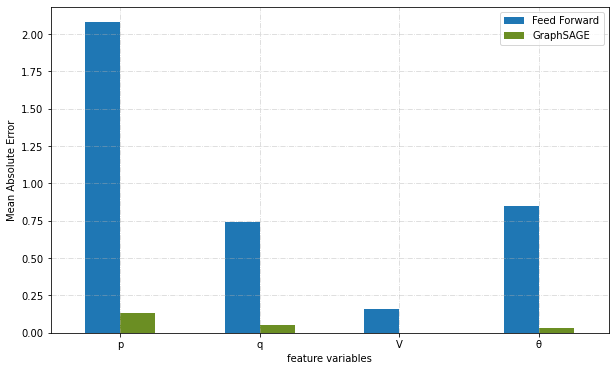

In [65]:
# plot MAE feature variables 14 nodes
fully_mae_v = mae_Fully['voltage']
fully_mae_th = mae_Fully['theta']
fully_mae_p = mae_Fully['Active_power']
fully_mae_q = mae_Fully['reactive_power']
pool_mae_v = mae_pool['voltage']
pool_mae_th = mae_pool['theta']
pool_mae_p = mae_pool['Active_power']
pool_mae_q = mae_pool['reactive_power']

index = ['p','q','V','θ']
GraphSAGE = [pool_mae_p,pool_mae_q, pool_mae_v,pool_mae_th]
FeedForward = [fully_mae_p,fully_mae_q,fully_mae_th,fully_mae_v]
df = pd.DataFrame({'Feed Forward' : FeedForward, 'GraphSAGE': GraphSAGE}, index = index)
df.plot.bar(rot =0, figsize=(10,6), color={"Feed Forward": "tab:blue", "GraphSAGE": "olivedrab"}).grid(alpha=0.5, linestyle='-.')
plt.ylabel('Mean Absolute Error')
plt.xlabel('feature variables')
plt.savefig('features_14nodes.pdf')

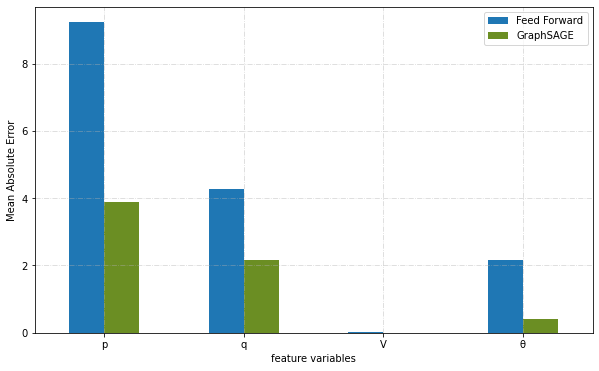

In [67]:
# plot MAE of feature variables 39-nodes
fully_mae_v = mae_Fully_39['voltage']
fully_mae_th = mae_Fully_39['theta']
fully_mae_p = mae_Fully_39['Active_power']
fully_mae_q = mae_Fully_39['reactive_power']
pool_mae_v = mae_39_pool['voltage']
pool_mae_th = mae_39_pool['theta']
pool_mae_p = mae_39_pool['Active_power']
pool_mae_q = mae_39_pool['reactive_power']

index = ['p','q','V','θ']
GraphSAGE = [pool_mae_p,pool_mae_q, pool_mae_v,pool_mae_th]
FeedForward = [fully_mae_p,fully_mae_q,fully_mae_th,fully_mae_v]
df = pd.DataFrame({'Feed Forward' : FeedForward, 'GraphSAGE': GraphSAGE}, index = index)
df.plot.bar(rot =0, figsize=(10,6), color={"Feed Forward": "tab:blue", "GraphSAGE": "olivedrab"}).grid(alpha=0.5, linestyle='-.')
plt.ylabel('Mean Absolute Error')
plt.xlabel('feature variables')
plt.savefig('features_39nodes.pdf')

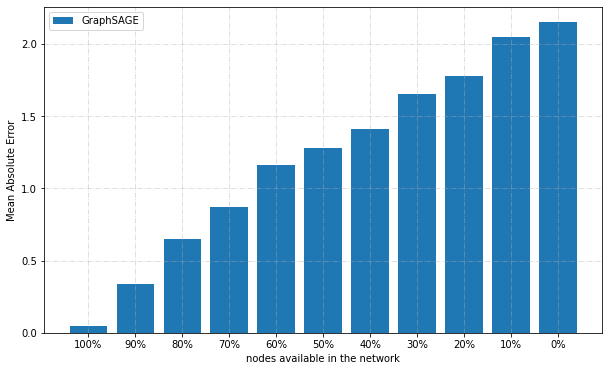

In [15]:
# plot MAE with missing nodes 

pool_0 = mae_pool['Testing']
pool_1 = mae_pool_1['Testing']
pool_2 = mae_pool_2['Testing']
pool_3 = mae_pool_3['Testing']
pool_4 = mae_pool_4['Testing']
pool_5 = mae_pool_5['Testing']
pool_6 = mae_pool_6['Testing']
pool_7 = mae_pool_7['Testing']
pool_8 = mae_pool_8['Testing']
pool_9 = mae_pool_9['Testing']
pool_10 = mae_pool_10['Testing']
pool_11 = mae_pool_11['Testing']
pool_12 = mae_pool_12['Testing']
pool_13 = mae_pool_13['Testing']
pool_14 = mae_pool_14['Testing']


index = ['100%','90%','80%','70%','60%','50%','40%','30%','20%','10%','0%']
rates = [pool_0,pool_1,pool_2,pool_3,pool_4,pool_5,pool_6,pool_7,pool_8,pool_9,pool_10,pool_11,pool_12,pool_13,pool_14]

plt.figure(figsize=(10,6))
plt.bar(range(len(index)), list(map(float,rates)) )
plt.xticks(range(len(index)), index)
plt.grid(alpha=0.5, linestyle='-.')
plt.legend(['GraphSAGE'])
plt.ylabel('Mean Absolute Error')
plt.xlabel('nodes available in the network')
plt.savefig('Final_missing.pdf')
plt.show()


powerflow solution : [[ 1.0599999e+00  0.0000000e+00 -1.3419879e+02 -6.0196134e-04]
 [ 1.0441203e+00 -2.7353346e+00 -4.4409142e+00  8.0524426e+00]
 [ 1.0286320e+00 -6.4215360e+00  4.0623310e+01  1.4036925e+00]
 [ 1.0321091e+00 -5.8520904e+00  2.6810831e+01 -2.1874945e+00]
 [ 1.0318469e+00 -5.0824404e+00  8.4284573e+00  1.7744120e+00]
 [ 1.0818917e+00 -8.6184397e+00  1.1143901e+01  2.2063966e+00]
 [ 1.0723493e+00 -7.8352637e+00  0.0000000e+00  0.0000000e+00]
 [ 1.0821943e+00 -7.8352633e+00 -7.9328984e-06 -6.0483670e+00]
 [ 1.0756602e+00 -8.8586636e+00  1.6651188e+01 -1.2614030e+01]
 [ 1.0694504e+00 -9.0979671e+00  9.5987444e+00  6.1858578e+00]
 [ 1.0731443e+00 -8.9518452e+00  2.5622947e+00  1.3177515e+00]
 [ 1.0739549e+00 -9.0660067e+00  3.4196646e+00  8.9696121e-01]
 [ 1.0716251e+00 -9.0959282e+00  7.5554991e+00  3.2460663e+00]
 [ 1.0648677e+00 -9.4578485e+00  7.7401919e+00  2.5973799e+00]]


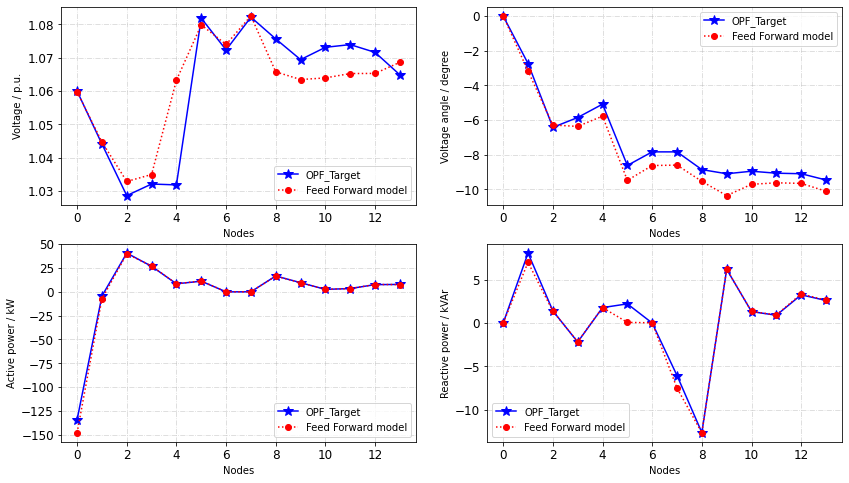

In [54]:
# to plot the variables predictions along with the target values

y_prediction = y_prediction_Fully.detach().cpu().numpy()#.view(n_nodes, batch_size, n_features).detach().cpu().numpy()

t = 2

# Prediction of NN
y_0 = y_prediction[t,:,:]
y_0_v = y_0[:,0]
y_0_a = y_0[:,1]
y_0_p = y_0[:,2]
y_0_q = y_0[:,3]

# OPF solution
o_0 = target_Fully[t,:,:].detach().cpu().numpy()
print('powerflow solution :' ,o_0[:,:])
o_0_v = o_0[:,0]
o_0_a = o_0[:,1]
o_0_p = o_0[:,2]
o_0_q = o_0[:,3]


plt.subplots(2,2, figsize=(14,8))
# Voltage
plt.subplot(2,2,1)
plt.plot(o_0_v, color='b',marker='*',markersize=10)
plt.plot(y_0_v, marker='o',linestyle = ':',color='r')
plt.grid(alpha=0.5, linestyle='-.')
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12 )  
plt.ylabel('Voltage / p.u.')
plt.xlabel('Nodes')
plt.legend(['OPF_Target','Feed Forward model'])
# plt.plot(np.ones(len(y_0_v)), linestyle='--', color='r')
# plt.plot(np.ones(len(y_0_v)), linestyle='--', color='r')

# Voltage angle
plt.subplot(2,2,2)
plt.plot(o_0_a, color='b',marker='*',markersize=10)
plt.plot(y_0_a,marker='o',linestyle = ':',color='r')
plt.grid(alpha=0.5, linestyle='-.')
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12 )  
plt.ylabel('Voltage angle / degree')
plt.xlabel('Nodes')
plt.legend(['OPF_Target','Feed Forward model'])

# Node active power
plt.subplot(2,2,3)
plt.plot(o_0_p,color = 'b',marker='*',markersize=10)
plt.plot(y_0_p,marker ='o', linestyle = ':',color = 'r')
plt.grid(alpha=0.5, linestyle='-.')
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12 )  
plt.ylabel('Active power / kW')
plt.xlabel('Nodes')
plt.legend(['OPF_Target','Feed Forward model'])

# Node reactive power
plt.subplot(2,2,4)
plt.plot(o_0_q,color='b',marker='*',markersize=10)
plt.plot(y_0_q, marker='o',linestyle = ':',color='r')
plt.grid(alpha=0.5, linestyle='-.')
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12 )  
plt.ylabel('Reactive power / kVAr')
plt.xlabel('Nodes')
plt.legend(['OPF_Target','Feed Forward model'])
plt.savefig('features_FF.pdf')
plt.show()





In [41]:
# this is a function to train the graph convolutional model

def model_Trainer(model,epochs):

    optimizer = torch.optim.Adam(model.parameters(),lr =0.000824550352196068, betas=(0.9, 0.999), eps=1e-08)#0.0022111414332470908)
    criterion = torch.nn.MSELoss()  
    n_nodes = 14
    n_features = 4

    model = model.to('cuda:0')
    model.train()
    loss_hist = list()
    epoch_loss_hist = []
    G = dgl.from_scipy(Y_14).to('cuda:0')

    start_time = time.time()
    for epoch in range(1, epochs+1):

        for x_b, y_b in train_loader:
           
            features = x_b   
            # features = Hide_Node(features,7)  
            features =features.reshape(n_nodes,batch_size*5)
            y_pred = model(G, features)
            loss = criterion(y_pred, y_b.view(n_nodes,batch_size,4))
            loss_hist.append(loss.item())  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = np.mean(np.array(loss_hist))
        epoch_loss_hist.append(epoch_loss)
        mae_batches = []
        for x_b, y_b in validation_loader:

            features = x_b
            # features = Hide_Node(features,7)
            features = features.reshape(n_nodes,batch_size*5) 
            y_pred_Tag = model(G, features)
            y_pred_Tag = y_pred_Tag.view(batch_size, n_nodes, 4).detach().cpu().numpy()
            for feature in np.arange(1,4,1):
                y_pred_Tag[:,:,feature] = mescaler[feature].inverse_transform(y_pred_Tag[:,:,feature])
            y_pred_Tag = torch.Tensor(y_pred_Tag ).to('cuda:0')
            mae_batches.append(MAE_torch(y_pred_Tag, y_b))
            
        mae_val = np.mean(np.array(mae_batches))          
        print('epoch: ', epoch, 'loss: ', loss.item(),'Testing mae is: ',mae_val)
    end_time = time.time()
    timer = end_time-start_time
    print('Training takes. %.2f seconds' %timer)
    return (model,epoch_loss_hist,timer)

In [ ]:
# print the parameters of the models 
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| layer1.weight |    2560    |
|  layer1.bias  |    512     |
| layer2.weight |  2097152   |
|  layer2.bias  |    4096    |
| layer3.weight |  8388608   |
|  layer3.bias  |    2048    |
| layer4.weight |  1048576   |
|  layer4.bias  |    512     |
| layer5.weight |    2048    |
|  layer5.bias  |     4      |
+---------------+------------+
Total Trainable Params: 11546116


11546116

In [12]:
# train the feed forward model
def Fully_connected_trainer(model,epochs):

  optimizer = torch.optim.Adam(model.parameters(),lr = 0.0007660602539084949,betas=(0.9, 0.999), eps=1e-08)
  criterion = torch.nn.MSELoss()

  n_features = 4
  model = model.to('cuda:0')
  model.train()
  loss_hist = list()
  epoch_loss_hist = []
  start_time = time.time()
  for epoch in range(1, epochs+1):
      for x_b, y_b in train_loader_14:
          parameters = x_b#Hide_Node(x_b,2)

          y_pred1 = model(parameters)
          loss = criterion(y_pred1, y_b)
          loss_hist.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      epoch_loss = np.mean(np.array(loss_hist))
      epoch_loss_hist.append(epoch_loss)   
      mae_batches = []

      for x_b, y_b in validation_loader_14:
          parameters = x_b#Hide_Node(x_b,2)

          y_pred_Tag = model(parameters)
          y_pred_Tag = y_pred_Tag.detach().cpu().numpy()
          for feature in np.arange(1,4,1):
              y_pred_Tag[:,:,feature] = mescaler[feature].inverse_transform(y_pred_Tag[:,:,feature])
          y_pred_Tag = torch.Tensor(y_pred_Tag ).to('cuda:0')
          mae_batches.append(MAE_torch(y_pred_Tag, y_b))
      mae_val = np.mean(np.array(mae_batches))
          
      print('epoch: ', epoch, 'loss: ', loss.item(),'validation mae is: ',mae_val)
  end_time = time.time()
  zeit = (end_time-start_time)
  print('Training takes. %.2f seconds' %zeit)
  return (model,epoch_loss_hist,zeit)

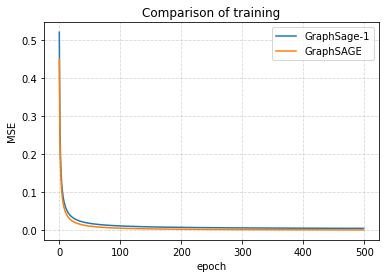

In [ ]:
# plot the training\ epochs
plt.title('Comparison of training')
plt.plot(epoch_loss_4_pool_1)
plt.plot(epoch_loss_4_pool)


plt.legend(['GraphSage-1','GraphSAGE'])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.grid(alpha=0.5,linestyle='--')
plt.show()

In [ ]:
# define an Objective function for the fully connected model in order to run a bayesian optimization
import torch.nn.functional as F
def train_Bayasian(parameters):
  # n_layers = 2 #parameters.get('n_layers',2)
  lr = parameters.get('lr',1e-4)
  factor = parameters.get('factor',20)
  feat_dr = parameters.get('feat_dr',0.5)
  # k = parameters.get('k',2)
  class SAGE_Bay(nn.Module):
      def __init__(self,
                  in_dim,
                  hidden_dim,
                  out_dim,              
                  ):
          super(SAGE_Bay, self).__init__()
          # self.g = g
          # self.layers = nn.ModuleList()
          # input layer
          # self.layers.append(TAGConv(in_feats, n_hidden,k=k))
          # hidden layers
          # for i in range(n_layers - 1):
          #     n_hidden = n_hidden*(k+1) 
              # self.layers.append(self.layers.append(TAGConv(n_hidden, n_hidden*(k+1),k=k)))
              
          # output layer
          # self.layers.append(TAGConv(n_hidden*(k+1), n_hidden,k)) #activation=None
          # self.dropout = nn.Dropout(p=dropout)
          # self.layers.append(nn.Linear(n_hidden*(k+1),n_classes))
          self.conv1 = SAGEConv(in_dim, hidden_dim,aggregator_type='gcn',feat_drop=feat_dr, bias= True)
          self.conv2 = SAGEConv(hidden_dim,hidden_dim*factor,aggregator_type='gcn',feat_drop=feat_dr, bias= True)
          self.fc1 = nn.Linear(hidden_dim*factor,out_dim) 
          self.HidDim =hidden_dim*factor
      def forward(self,g, features):
          # h = features
          # for i, layer in enumerate(self.layers):
          #   # if i != 0:
          #   #     h = self.dropout(h)
          #   h = layer(g, h)
          h = F.relu(self.conv1(g, features))
          h = F.relu(self.conv2(g, h))
          h = h.view(-1,self.HidDim)
          h = self.fc1(h)
          h = h.view(14,batch_size,4)
          return h

  model_bay = SAGE_Bay(4*batch_size,512,4*batch_size)
  model_bay = model_bay.to('cuda:0')
  epochs = 250
  #optimizer = torch.optim.Adam(itertools.chain(model.parameters))
  optimizer = torch.optim.Adam(model_bay.parameters(),lr = lr)
  criterion = torch.nn.MSELoss()
  n_nodes = 14
  n_features = 4

  model_bay.train()
  loss_hist = list()
  G = dgl.DGLGraph(Y_14)
  for epoch in range(1, epochs+1):

      for x_b, y_b in train_loader:
          y_pred = model_bay(G, x_b[:,:,0:4].reshape(n_nodes,batch_size*4))
          loss = criterion(y_pred, y_b.view(n_nodes,batch_size,n_features))
          loss_hist.append(loss.item())
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      rmse_batches = []
      for x_b, y_b in validation_loader:
    
          y_pred_Tag = model_bay(G, x_b[:,:,0:4].reshape(n_nodes,batch_size*4)) 
          y_pred_Tag = y_pred_Tag.view(batch_size, n_nodes, n_features).detach().cpu().numpy()
          for feature in np.arange(1,4,1):
              y_pred_Tag[:,:,feature] = mescaler[feature].inverse_transform(y_pred_Tag[:,:,feature])
          y_pred_Tag = torch.Tensor(y_pred_Tag ).to('cuda:0')
          rmse_batches.append(RMSE_torch(y_pred_Tag, y_b))
      rmse_testing = np.mean(np.array(rmse_batches))

  return (rmse_testing)
    

In [ ]:
!pip install ax-platform

     |████████████████████████████████| 501kB 3.4MB/s 
     |████████████████████████████████| 225kB 15.9MB/s 
     |████████████████████████████████| 296kB 15.4MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.2.1-py2.py3-none-any.whl size=463973 sha256=9c7ab84a623c6ae2cf0083b2374561d1f2959b041257a3219cf4d6dcf63cc7fc
  Stored in directory: /root/.cache/pip/wheels/2e/d5/dc/0a984c2acc9b35f9860f543c10732442c2cd5719d923236017
Successfully built gpytorch


In [ ]:
# define the hyperparameters to be searched in the bayesian optimization
import ax
from ax import optimize, RangeParameter, ChoiceParameter, FixedParameter, ParameterType 

parameters = [
    # {'name':'n_layers', 'type':'choice', 'values':[1,2,3], 'parameter_type':'int'},
    # {'name':'k', 'type':'choice', 'values':[2,3,4], 'parameter_type':'int'},
    {'name':'lr','type':'range', 'bounds':[1e-8,1e-1], 'parameter_type':'float', 'log_scale':True},
    {'name':'factor','type':'choice', 'values':[30,100],'parameter_type':'int'},
    # {'name':'feat_dr','type':'range', 'bounds':[0.1,0.7],'parameter_type':'float'}

    # {'name':'batch_size','type':'choice', 'values':[16,32,64,128],'parameter_type':'int'}

]


best_parameters, best_values, experiment, model = optimize(
    parameters = parameters,
    # Booth function
    evaluation_function=train_Bayasian,
    objective_name='rmse_testing',
    minimize=True,
    total_trials=30)

print(best_parameters)
print(best_values)

In [ ]:
# load model
best_model = SAGE(5*16,256,4*16)
best_model.load_state_dict(torch.load('/content/best_model_Dic.pth'))
best_model.eval()

SAGE(
  (myLayer1): TAGConv(
    (lin): Linear(in_features=240, out_features=256, bias=True)
  )
  (myLayer2): TAGConv(
    (lin): Linear(in_features=768, out_features=1280, bias=True)
  )
  (myLayer3): TAGConv(
    (lin): Linear(in_features=2560, out_features=2560, bias=True)
  )
  (SageLayer1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=80, out_features=80, bias=True)
    (fc_self): Linear(in_features=80, out_features=256, bias=True)
    (fc_neigh): Linear(in_features=80, out_features=256, bias=True)
  )
  (SageLayer2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=256, out_features=256, bias=True)
    (fc_self): Linear(in_features=256, out_features=2560, bias=True)
    (fc_neigh): Linear(in_features=256, out_features=2560, bias=True)
  )
  (SageLayer3): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=2560, out_features=2560, bias=True)
    (fc_self)

In [ ]:
# save model
def save_file(data):
    """
    Saving the pickle.
    """
    with open('Model_4/4.pickle', 'wb') as handle: 
        # PATH = 'Model_4/4.pickle'
        torch.save(model_unknowns, handle)

    return
save_file(Model_Tag)

In [ ]:
# bayesian optimization function for the graph convolutional model
import torch.nn.functional as F
def train_Fully_Bayasian(parameters):
    n_layers = 3#parameters.get('n_layers',4)
    lr = 0.0007660602539084949#parameters.get('lr',1e-2)
    k = 2#parameters.get('k',4)
    lamb = parameters.get('lamb',0.0001)
    # class Fully_connected_Bay(nn.Module):
    #     def __init__(self,
    #                 in_dim,
    #                 hidden_dim,
    #                 out_dim,              
    #                 ):
    #         super(Fully_connected_Bay, self).__init__()
    #         self.layers = nn.ModuleList()
    #         # input layer
    #         self.in_layer = nn.Linear(in_dim,hidden_dim,bias=True)
    #         # hidden layers
    #         for i in range(n_layers - 1): 
    #             self.layers.append(nn.Linear(hidden_dim, hidden_dim*k,bias=True))
    #             hidden_dim = hidden_dim*k
    #         # hidden_dim = hidden_dim/k   
    #         # output layer
    #         self.out_layer = nn.Linear(hidden_dim, out_dim,bias = True)
    #         # self.dropout = nn.Dropout(p=dropout)
    #         # self.layers.append(nn.Linear(n_hidden*(k+1),n_classes))

    #     def forward(self, features):
    #         h = features
    #         # print(h.shape)
    #         h = F.relu(self.in_layer(h))
    #         # print(h.shape)
    #         for i,layer in enumerate(self.layers):
    #           h = F.relu(self.layers[i](h))
    #           # print(h.shape,i)
    #         h = self.out_layer(h)
    #         # print(h.shape)
    #         return h

    model_Fully_bay = Fully_Connected(5,512,4)
    model_Fully_bay = model_Fully_bay.to('cuda:0')
    epochs = 100
    #optimizer = torch.optim.Adam(itertools.chain(model.parameters))
    optimizer = torch.optim.Adam(model_Fully_bay.parameters(),lr = lr)
    criterion = torch.nn.MSELoss()
    n_nodes = 14
    n_features = 4
    model_Fully_bay.train()
    loss_hist = list()

    for epoch in range(1, epochs+1):
        for x_b, y_b in train_loader:
            y_pred1 = model_Fully_bay(x_b)
            loss = criterion(y_pred1, y_b)
            # i = 0
            lambdaa = lamb
            l2_reg = 0 
            for param in model_Fully_bay.parameters():
              # i+=1
               l2_reg += torch.sqrt(torch.norm(param))
            loss += (lambdaa * l2_reg)
          
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        rmse_batches = []
    for x_b, y_b in validation_loader:
        y_pred2 = model_Fully_bay(x_b)
        y_pred2 = y_pred2.detach().cpu().numpy()
        for feature in np.arange(1,4,1):
            y_pred2[:,:,feature] = mescaler[feature].inverse_transform(y_pred2[:,:,feature])
        y_pred2= torch.Tensor(y_pred2).to('cuda:0')
        rmse_batches.append(RMSE_torch(y_pred2, y_b))
    rmse_testing = np.mean(np.array(rmse_batches))
    return (rmse_testing)
    

In [ ]:
import ax
from ax import optimize, RangeParameter, ChoiceParameter, FixedParameter, ParameterType 
# Define Hyperparameters
parameters = [
              {'name':'lambd' ,'type':'range', 'bounds':[1e-8,1e-1], 'parameter_type':'float', 'log_scale':True}
    # {'name':'n_layers', 'type':'choice', 'values':[3,4,5,6,7], 'parameter_type':'int'},
    # {'name':'k', 'type':'range', 'bounds':[2,20], 'parameter_type':'int'},
    # {'name':'lr','type':'range', 'bounds':[1e-4,1e-1], 'parameter_type':'float', 'log_scale':True}

    # {'name':'feat_dr','type':'range', 'bounds':[0.1,0.7],'parameter_type':'float'}

    # {'name':'batch_size','type':'choice', 'values':[16,32,64,128],'parameter_type':'int'}

]


best_parameters, best_values, experiment, model = optimize(
    parameters = parameters,
    # Booth function
    evaluation_function=train_Fully_Bayasian,
    objective_name='rmse_testing',
    minimize=True,
    total_trials=20)
print(best_parameters)
print(best_values)